# Setting up Colab notebook

In [0]:
pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [0]:
# Import relavant libraries to load data 
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Creating a directory for kaggle
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
# Importing API key into colab 
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"josephjacob","key":"67f4e3116c806e859549344b7283f845"}'}

In [0]:
# copy the API key to the kaggle directory we created
!cp kaggle.json ~/.kaggle/

In [0]:
# Downloading kaggle data onto colab
!kaggle datasets download -d ianmoone0617/flower-goggle-tpu-classification

 94% 249M/264M [00:03<00:00, 45.8MB/s]
100% 264M/264M [00:04<00:00, 68.7MB/s]


In [0]:
# Unzipping the data.zip
!unzip flower-goggle-tpu-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: flower_tpu/flower_tpu/test/test/51d6b9846.jpeg  
  inflating: flower_tpu/flower_tpu/test/test/51e3f656c.jpeg  
  inflating: flower_tpu/flower_tpu/test/test/51eb14267.jpeg  
  inflating: flower_tpu/flower_tpu/test/test/51f607616.jpeg  
  inflating: flower_tpu/flower_tpu/test/test/51f6d891d.jpeg  
  inflating: flower_tpu/flower_tpu/test/test/52171b028.jpeg  
  inflating: flower_tpu/flower_tpu/test/test/52178db26.jpeg  
  inflating: flower_tpu/flower_tpu/test/test/52189b48a.jpeg  
  inflating: flower_tpu/flower_tpu/test/test/52232fe3f.jpeg  
  inflating: flower_tpu/flower_tpu/test/test/5227d80bf.jpeg  
  inflating: flower_tpu/flower_tpu/test/test/5228fb3fa.jpeg  
  inflating: flower_tpu/flower_tpu/test/test/522ea009b.jpeg  
  inflating: flower_tpu/flower_tpu/test/test/5233ee8fe.jpeg  
  inflating: flower_tpu/flower_tpu/test/test/5235c6c53.jpeg  
  inflating: flower_tpu/flower_tpu/test/test/52378ff5a.jpeg  
  inflating: flower

In [0]:
# Import relevant libraries
# import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout

from sklearn.model_selection import train_test_split

from PIL import Image

In [0]:
# Checking the version of tensorflow
print(tf.__version__)

2.2.0-rc2


# Data

In [0]:
# Loading and displaying the flower_idx csv file
df_flowers = pd.read_csv('/content/flowers_idx.csv')
df_flowers

,id,flower_cls
0,7486,cape flower
1,9454,cape flower
2,6974,cape flower
3,4739,cape flower
4,8783,cape flower
...,...,...
16460,13384,windflower
16461,16462,windflower
16462,13493,windflower
16463,15576,windflower


In [0]:
# Sorting the flowers_idx dataframe by id attribute
df_flowers.sort_values('id', inplace = True)
df_flowers.reset_index(drop = True, inplace = True)
df_flowers

,id,flower_cls
0,0,wild pansy
1,1,rose
2,2,king protea
3,3,gazania
4,4,rose
...,...,...
16460,16460,cyclamen
16461,16461,azalea
16462,16462,windflower
16463,16463,daisy


In [0]:
# Loading and displaying the flower_label csv file
df_labels = pd.read_csv('/content/flowers_label.csv')
df_labels

,label,flower_class
0,0,pink primrose
1,1,hard-leaved pocket orchid
2,2,canterbury bells
3,3,sweet pea
4,4,wild geranium
...,...,...
99,99,blanket flower
100,100,trumpet creeper
101,101,blackberry lily
102,102,common tulip


# Creating inputs & targets

We have our data in the form of images labelled from 0-16464 & two csv files. We must check the numerical image label & match it with the flower class from the flower_idx dataframe. We must the obtain label that matches this flower class from the labels dataframe.

In [0]:
# Loading the images and their labels
# Lists to load data into
x = [] # images
y = [] # labels

# Path to folder with training images
base = "/content/flower_tpu/flower_tpu/flowers_google/flowers_google//"


# Iterating to store images and labels in their respective lists
for idx in range(len(df_flowers)):
  # get the flower row
  flower = df_flowers.iloc[idx]
  # create flower path
  path = f"{base}{flower.id}.jpeg"
  #load image
  img = Image.open(path)
  # convert to numpy
  img = np.array(img)
  #save to X
  x.append(img)
  # get label
  label = df_labels[df_labels['flower_class'] == flower.flower_cls].label.values[0]
  # save to y
  y.append(label)

In [0]:
# Checking the image shape
IMG_SHAPE = img.shape
IMG_SHAPE

(224, 224, 3)

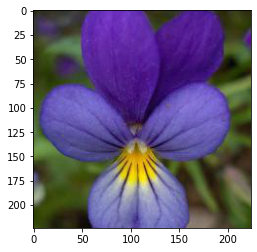

In [0]:
# Checking if the image and labels are accurately scored in respective lists
plt.imshow(x[0])

In [0]:
# Ensuring the target (label) matches the flower class
y[0]

51

In [0]:
# Check complete. Lists are accurate.
df_labels['flower_class'][51]

'wild pansy'

In [0]:
# Splitting the labelled training data in train & validation data 
x_train, x_validation, y_train, y_validation = train_test_split(x, y, random_state=12, test_size=0.2)

In [0]:
# Converting data to numpy ndarrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_validation = np.asarray(x_validation)
y_validation = np.asarray(y_validation)

In [0]:
# Checking the shape of train images
x_train.shape

(13172, 224, 224, 3)

In [0]:
# Checking the shape of train labels
y_train.shape

(13172,)

In [0]:
# Checking the shape of validation images
y_train.shape

(13172,)

In [0]:
# Checking the shape of validation labels
y_validation.shape

(3293,)

# Model

## Transfer Learning

Using the VGG16 model developed by Visual Geometry Group - University of Oxford to train our model. I am going to leave the top layers frozen and fine tune the classification layers.

In [0]:
# instantiating a VGG16 model pre-loaded with weights trained on ImageNet
# Specifying the include_top=False argument to load a network that doesn’t include the classification layers
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [0]:
# Freezing the convoltion layers to avoid updation of weight
VGG16_MODEL.trainable=False
# Global average pooling operation for spatial data
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# layer to convert these features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(104,activation='softmax')

In [0]:
# Stacking VGG model with fine tuned classification layers to build model
model = tf.keras.Sequential([
  VGG16_MODEL,
  global_average_layer,
  prediction_layer
])

In [0]:
# Compiling the model
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 104)               53352     
Total params: 14,768,040
Trainable params: 53,352
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_best_only = True,
    save_weights_only=True,
    period=2)

In [0]:
# Instantiating early stop callback to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping()

In [0]:
# Training the model
history = model.fit(x_train, y_train, epochs=100, batch_size=30, callbacks=[early_stopping], validation_data=(x_validation, y_validation), verbose=1)

Epoch 1/100
440/440 [==============================] - 41s 94ms/step - loss: 4.2493 - accuracy: 0.3539 - val_loss: 2.1807 - val_accuracy: 0.5354
Epoch 2/100
440/440 [==============================] - 40s 92ms/step - loss: 1.4566 - accuracy: 0.6546 - val_loss: 1.5847 - val_accuracy: 0.6465
Epoch 3/100
440/440 [==============================] - 40s 92ms/step - loss: 0.9439 - accuracy: 0.7549 - val_loss: 1.4318 - val_accuracy: 0.6723
Epoch 4/100
440/440 [==============================] - 40s 92ms/step - loss: 0.7042 - accuracy: 0.8058 - val_loss: 1.3515 - val_accuracy: 0.6930
Epoch 5/100
440/440 [==============================] - 40s 92ms/step - loss: 0.5577 - accuracy: 0.8427 - val_loss: 1.3881 - val_accuracy: 0.7045


In [0]:
!ls {checkpoint_dir}

ls: cannot access 'training_2': No such file or directory


In [0]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

In [0]:
# Re-evaluate the model
loss, acc = model.evaluate(x_validation,  y_validation, verbose=2)
print("Model, accuracy: {:5.2f}%".format(100*acc))

103/103 - 8s - loss: 1.3889 - accuracy: 0.7045
Model, accuracy: 70.45%


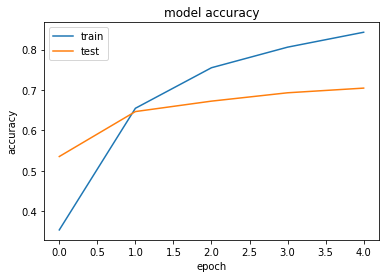

In [0]:
# Plotting the model accuracy 
plt.plot(history.history['accuracy'])  # Training accuracy
plt.plot(history.history['val_accuracy'])  # Validation accuracy
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

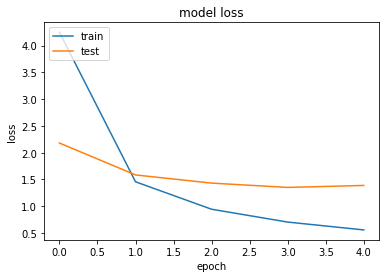

In [0]:
# Plotting the loss 
plt.plot(history.history['loss']) # Training accuracy
plt.plot(history.history['val_loss']) # Validation accuracy
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing the model on unseen data

In [0]:
# Importing relevant libraries
import cv2
import os

In [0]:
# Loading the test images from the test folder
folder = "/content/flower_tpu/flower_tpu/test/test"
test_images = []
for filename in os.listdir(folder):
  img = cv2.imread(os.path.join(folder,filename))
  if img is not None:
    img = np.array(img)
    test_images.append(img)

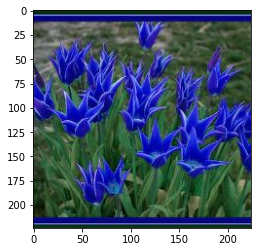

In [0]:
# Plotting a test image to ensure that it is stored properly
plt.imshow(test_images[0])

In [0]:
# Converting test images list into an ndarray
test_images = np.asarray(test_images)

In [0]:
# Checking the shape
test_images.shape

(7382, 224, 224, 3)

In [0]:
# Making predictions
test_labels = model.predict_classes(test_images)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


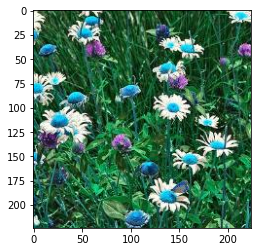

In [0]:
# Dispaling a random test image
plt.imshow(test_images[3526])

In [0]:
# Checking the predicted label
df_labels.iloc[test_labels[3526]]

label              48
flower_class    daisy
Name: 48, dtype: object

## The model got it right! It is a daisy!

Link to image of daisy (in a field) -  https://www.featurepics.com/online/Daisy-Field-705729.aspx